# Пример использования библиотеки BigARTM для тематического моделирования
## Для Bigartm v0.8.0
### Редактировал Максим Чурилин

Импортируем BigARTM:

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import artm

Первое считывание данных (преобразуем удобный для человека формат в формат, который использует модель):

In [45]:
batch_vectorizer = artm.BatchVectorizer(
    data_path="data/08_school.txt", data_format="vowpal_wabbit", target_folder=".tmp/school_batches", batch_size=100
)

В следующий раз данные можно считывать уже из батчей:

In [46]:
batch_vectorizer = artm.BatchVectorizer(data_path=".tmp/school_batches", data_format='batches')

Создаем объект модели:

In [47]:
T = 10   # количество тем
model_artm = artm.ARTM(num_topics=T, topic_names=["sbj"+str(i) for i in range(T)], class_ids={"text":1}, 
                       num_document_passes=1, reuse_theta=True, cache_theta=True, seed=-1)
# число после названия модальностей - это их веса

Создаем словарь и инициализируем модель с его помощью

In [48]:
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)

In [49]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                           use_unigram_document_model=False,
                                           dictionary='dictionary'))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', class_id="text"))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"))

In [50]:
model_artm.initialize('dictionary')

Строим модель. Offline - проходит по всей коллекции много раз. Удобно, когда коллекция маленькая.

In [51]:
%time model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)

Wall time: 7.89 s


Необходимое число итераций можно отслеживать по графику перплексии. Когда она перестала меняться, модель сошлась.

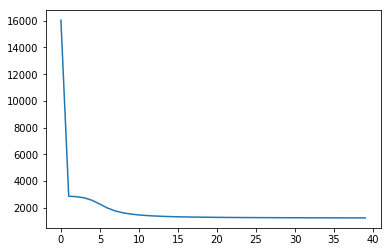

In [52]:
plt.plot(model_artm.score_tracker["PerplexityScore"].value[:40])

Выведем топы слов:

In [53]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:    
        print word,
    print

sbj0:  право быть который человек ребенок язык они также семья это являться как для свой мочь
sbj1:  что свой который быть это герой его этот человек они она ребенок как жизнь такой
sbj2:  предложение слово который что это например быть как сила или такой речь они этот если
sbj3:  который что ядро энергия это вода этот земля быть масса атом как температура такой океан
sbj4:  пушкин поэт который что стихотворение это быть свой этот звук год весь его лирика такой
sbj5:  x быть a b число этот при функция уравнение что это для если ток который
sbj6:  человек который свой что жизнь его быть это герой как произведение литература этот для русский
sbj7:  который человек общество развитие социальный быть это как политический себя государство век культура жизнь для
sbj8:  страна государство который население быть территория этот год являться сша что время африка хозяйство также
sbj9:  быть который год государство война свой что становиться первый как весь время империя армия военный


Давайте посмотрим также на разреженность матриц:

In [54]:
print model_artm.score_tracker["SparsityPhiScore"].last_value
print model_artm.score_tracker["SparsityThetaScore"].last_value

0.75459345301
0.106092436975


В темах много общеупотребительных слов (так называемой, фоновой лексики). Чтобы этого избежать, будем использовать разреживающий регуляризатор для матрицы фи. Он будет подавлять слова, которые имеют большую частоту во всей коллекции.

In [55]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-100, dictionary=dictionary))
#если вы хотите применять регуляризатор только к некоторым модальностям, указывайте это в параметре class_ids: class_ids=["text"]

In [56]:
%time model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

Wall time: 3.79 s


In [57]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:    
        print word,
    print

sbj0:  право быть который человек ребенок язык они семья также это являться для свой время русский
sbj1:  что свой который быть это герой человек его этот она жизнь они ребенок как такой
sbj2:  предложение слово который что это например быть как сила или такой речь они этот если
sbj3:  который что ядро энергия это вода этот земля быть масса атом как температура такой океан
sbj4:  пушкин поэт который что стихотворение быть свой это звук этот год весь его лирика произведение
sbj5:  x быть a b число этот при функция уравнение что это для если ток который
sbj6:  человек который свой что жизнь его быть это герой как произведение литература этот для русский
sbj7:  который человек общество развитие социальный быть как это политический государство себя культура жизнь век для
sbj8:  страна государство население который быть территория этот год являться африка время что хозяйство также сша
sbj9:  быть который год государство война свой что становиться первый как весь военный время империя армия


In [58]:
print model_artm.score_tracker["SparsityPhiScore"].last_value
print model_artm.score_tracker["SparsityThetaScore"].last_value

0.801751661594
0.285084033613


Попробуем менять коэффициент регуляризации:

In [59]:
model_artm.regularizers['SparsePhi'].tau = -5*1e4

In [60]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [61]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:    
        print word,
    print

sbj0:  право язык свобода семья гражданин английский правовой религиозный гражданский суд порядок орган честь will is
sbj1:  ребенок лермонтов поэма сказка отец молодой хороший сюжет любить гоголь комедия ничто романтизм жена эпос
sbj2:  слово предложение например случай работа простой предмет какой речь глагол физика скорость свет кто угол
sbj3:  земля энергия вода ядро масса количество природный океан атом движение температура частица заряд море располагать
sbj4:  пушкин поэт стихотворение звук лирика писать стих поэзия русь былина почти любовный бумага князь сравнение
sbj5:  x при a число если b функция тело два получать можно уравнение равный пример корень
sbj6:  человек свой его жизнь герой русский произведение мир литература история сам автор литературный личность писатель
sbj7:  общество век развитие социальный политический отношение процесс форма экономический производство культура характер система понятие роль
sbj8:  государство страна территория население город северный миров

In [62]:
# еще раз посмотрим на разреженность
print model_artm.score_tracker["SparsityPhiScore"].last_value
print model_artm.score_tracker["SparsityThetaScore"].last_value

0.900080750357
0.331512605042


Обратите внимание, что разреживать модель рекомендуется только после того, как она сошлась без регуляризации.

Сохранение и загрузка модели:

In [63]:
model_artm.save(".tmp/my_model")

In [64]:
model_artm.load(".tmp/my_model")

Можно попросить матрицы в чистом виде:

In [65]:
phi = model_artm.get_phi()

In [66]:
phi

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9
домохозяйка,0.00000,0.000000,0.000123,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
институт,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002557,0.000000,0.000000
машинка,0.00000,0.000000,0.000000,0.000000,0.000257,0.000000,0.000000,0.000000,0.000000,0.000000
прочий,0.00000,0.001465,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
навязнуть,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000102,0.000000,0.000000,0.000000
физиология,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000247,0.000000,0.000000
истязать,0.00024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
выборы,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000995
кндр,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000280,0.000000
федерализм,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000093,0.000000


Матрица вероятностей тем в документах.

In [67]:
theta = model_artm.get_theta()
theta

,101,102,103,104,105,106,107,108,109,110,...,391,392,393,394,395,396,397,398,399,400
sbj0,0.007722,0.000000,0.035433,0.000000,0.372402,0.006303,0.059761,0.000000,0.000000,0.010898,...,0.049550,0.019062,0.000000,0.013514,0.029998,0.103560,0.044523,0.018182,0.000000,0.00000
sbj1,0.007722,0.000000,0.074803,0.000000,0.097570,0.370327,0.019975,0.499678,0.004405,0.014460,...,0.148557,0.111524,0.585859,0.027027,0.000000,0.000000,0.014981,0.022985,0.000000,0.00000
sbj2,0.000000,0.000000,0.377679,0.000000,0.038688,0.012721,0.040075,0.031395,0.070485,0.026882,...,0.044854,0.033457,0.000000,0.695340,0.008628,0.251099,0.019454,0.009091,0.033784,0.00000
sbj3,0.023166,0.786325,0.031496,0.752688,0.057540,0.000000,0.107570,0.000000,0.638617,0.050056,...,0.040588,0.000000,0.000000,0.027027,0.000000,0.000000,0.165519,0.000000,0.000000,0.68750
sbj4,0.007722,0.000000,0.007874,0.000000,0.009346,0.162059,0.003984,0.013393,0.000000,0.005376,...,0.000000,0.018587,0.000000,0.047297,0.410290,0.019986,0.007735,0.000000,0.027027,0.25364
sbj5,0.000000,0.000000,0.039370,0.000000,0.051508,0.051428,0.063745,0.000000,0.251101,0.043011,...,0.031722,0.000000,0.000000,0.000000,0.060645,0.087379,0.000000,0.000000,0.885135,0.00000
sbj6,0.383961,0.000000,0.322835,0.000000,0.126168,0.212185,0.350598,0.388164,0.035392,0.123656,...,0.081172,0.482797,0.414141,0.128970,0.000000,0.032544,0.078652,0.050635,0.054054,0.00000
sbj7,0.281853,0.000000,0.086614,0.000000,0.079439,0.033710,0.079681,0.017857,0.000000,0.725660,...,0.148649,0.115242,0.000000,0.027027,0.395038,0.000000,0.089888,0.068182,0.000000,0.00000
sbj8,0.077905,0.213675,0.000000,0.247312,0.115936,0.014713,0.191180,0.000000,0.000000,0.000000,...,0.054054,0.011152,0.000000,0.000000,0.061065,0.404349,0.127341,0.095455,0.000000,0.05886
sbj9,0.209949,0.000000,0.023895,0.000000,0.051402,0.136555,0.083431,0.049512,0.000000,0.000000,...,0.400854,0.208178,0.000000,0.033798,0.034335,0.101083,0.451908,0.735471,0.000000,0.00000


Если бы у нас были новые батчи, по которым мы не строим модель, а хотим только получить матрицу theta, можно пользоваться методом transform.

In [68]:
theta_test = model_artm.transform(batch_vectorizer)